1. Get the country-specific covid case data from [here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv). (Note pandas allows you to load a csv file from a URL. Make sure to use the "raw" link to the file on github.). Pick a country. Let $Y_t$ be the case count for day $t$ since the outbreak onset for that country. That is, process the time series so that $t=0$ is the first day with more than 0 cases. Then, fit a distributed lag linear model as follows.  
$$
Y_t = \alpha_0 + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_k Y_{t-5} + \epsilon_t
$$ 
That is, see how the last five days predicts the current day. Report and interpret the coefficients.

In [43]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# define the lag function
def lag(a, l):    
    b1 = a[:-l]
    b2 = [np.nan] * l
    b = np.concatenate((b2, b1))
    return b 

# Get the country-specific covid case data
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

# Country country A, Germany
# Select Germany as the picked country A, then remove unnecessary columns
df = df.loc[df['Country/Region'] == 'Germany'].reset_index(drop=True)
df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True, axis=1)
# remove the leading zero
df = df.loc[:, (df != 0).all()]
# convert to array, and reshape it as one vector
arr = np.array(df).reshape((len(df.T),))
y_l5 = arr[5:]
y_l4 = lag(arr, 1)[5:]
y_l3 = lag(arr, 2)[5:]
y_l2 = lag(arr, 3)[5:]
y_l1 = lag(arr, 4)[5:]
y = lag(arr, 5)[5:]
# create the new and main dataframe for the regression analysis
columns = ["Y", "Y_L1", "Y_L2", "Y_L3", "Y_L4", "Y_L5"]
data = np.stack((y, y_l1, y_l2, y_l3, y_l4, y_l5), axis=1)
df_A = pd.DataFrame(data=data, columns=columns)

# Interpretation of linear regression coefficients
results = smf.ols('Y ~ Y_L1 + Y_L2 + Y_L3  + Y_L4 + Y_L5', data=df_A).fit()
print(results.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     1.000     
Dependent Variable: Y                AIC:                18834.8268
Date:               2022-04-17 13:42 BIC:                18862.9793
No. Observations:   806              Log-Likelihood:     -9411.4   
Df Model:           5                F-statistic:        4.246e+06 
Df Residuals:       800              Prob (F-statistic): 0.00      
R-squared:          1.000            Scale:              8.1850e+08
-------------------------------------------------------------------
               Coef.    Std.Err.    t    P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept    3976.8178 1308.9005  3.0383 0.0025 1407.5328 6546.1029
Y_L1            1.5565    0.0351 44.3150 0.0000    1.4876    1.6255
Y_L2           -0.5416    0.0647 -8.3644 0.0000   -0.6687   -0.4145
Y_L3           -0.1332    0.0671 -1.9861 0.0474   -0.2648   -0.001

The interpretation of the $Y_{t-1}$ coefficient, i.e. $β1$, is as follows: we estimate an expected 1.5541 increase in $Y_t$ per 1 unit change in $Y_{t-1}$, with all of the remaining model terms held constant (however, its p-value is not significant). That is, it’s improtant to remember that coefficients are adjusted for the linear associations with other variables. Also, we should note that both the $Y_t$ and $Y_{t-1}$ variables have had the linear association with the other variables removed before relating them. The same is true for the other variables. The coefficients for $Y_{t-2}$, $Y_{t-3}$, $Y_{t-4}$, and $Y_{t-5}$ are interpreted similarly. In fact, they are the relationships between $Y_t$ and dependent variables where the linear associations with the other variables had been removed from them both.

--------------------------------------------------------------------------------------
2. Refer to the previous question. Let A and B be your two countries. Create a plot of time versus prediction error for the following: 
  a. fit the model on (all of) A and apply it to (all of) A, 
  b. fit A on the first half of the time for A, apply it to all of A.
This contrasts the forecasting error, a model fit using prior data applied to future data that didn't get to impact the fitting, with the training error. 

Text(0, 0.5, 'Prediction error (y-ŷ)')

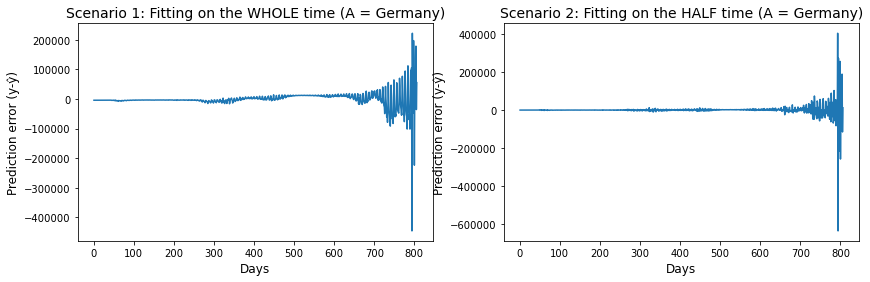

In [44]:
# forecasting error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

X = np.array(df_A[['Y_L1', 'Y_L2', 'Y_L3', 'Y_L4', 'Y_L5']])
y = np.array(df_A['Y'])

# set the subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# scenario 1: fit the model on (all of) A and apply it to (all of) A
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r-squared
α = reg.intercept_
β1,β2,β3,β4,β5 = reg.coef_[0],reg.coef_[1],reg.coef_[2],reg.coef_[3],reg.coef_[4]
# y = α + β1*5 + β2*18 + β3*28 + β4*43 + β5*61
# calculating the prediction error
err = []
for idx in range(len(df_A)): # idx = row index
    y_prd = reg.predict(np.array([df_A[['Y_L1', 'Y_L2', 'Y_L3', 'Y_L4', 'Y_L5']].iloc[idx]]))
    y_obs = np.array([df_A[['Y']].iloc[idx]]).flatten()
    err.append(y_obs - y_prd)
# plot of time versus prediction error
p = sns.lineplot(np.arange(1,len(df_A)+1), np.array(err).flatten(), ax=ax[0])
p.set_title("Scenario 1: Fitting on the WHOLE time (A = Germany)", fontsize = 14)
p.set_xlabel("Days", fontsize = 12)
p.set_ylabel("Prediction error (y-ŷ)", fontsize = 12)

# scenario 2: fit A on the first half of the time for A, apply it to all of A
idx_half = round(len(df_A)/2) # get the index for the half split of X
reg = LinearRegression().fit(X[:idx_half], y[:idx_half])
# calculating the prediction error
err = []
for idx in range(len(df_A)): # idx = row index
    y_prd = reg.predict(np.array([df_A[['Y_L1', 'Y_L2', 'Y_L3', 'Y_L4', 'Y_L5']].iloc[idx]]))
    y_obs = np.array([df_A[['Y']].iloc[idx]]).flatten()
    err.append(y_obs - y_prd)
# plot of time versus prediction error
p = sns.lineplot(np.arange(1,len(df_A)+1), np.array(err).flatten(), ax=ax[1])
p.set_title("Scenario 2: Fitting on the HALF time (A = Germany)", fontsize = 14)
p.set_xlabel("Days", fontsize = 12)
p.set_ylabel("Prediction error (y-ŷ)", fontsize = 12)


--------------------------------------------------------------------------------------
3. Plot the errors over time for applying the model from country A and applying it to a new country, B that you pick. This is out of sample error.

Text(0, 0.5, 'Prediction error (y-ŷ)')

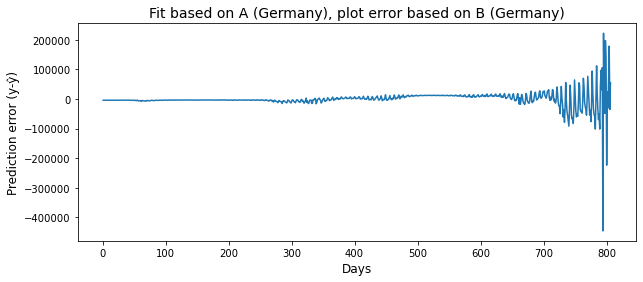

In [45]:
# out of sample error

# Select country B, Germany
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df.loc[df['Country/Region'] == 'Germany'].reset_index(drop=True)
df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True, axis=1)
# remove the leading zero
df = df.loc[:, (df != 0).all()]
# convert to array, and reshape it as one vector
arr = np.array(df).reshape((len(df.T),))
y_l5, y_l4, y_l3, y_l2, y_l1 = arr[5:], lag(arr, 1)[5:], lag(arr, 2)[5:], lag(arr, 3)[5:], lag(arr, 4)[5:]
y = lag(arr, 5)[5:]
# create the new and main dataframe for the regression analysis
columns = ["Y", "Y_L1", "Y_L2", "Y_L3", "Y_L4", "Y_L5"]
data = np.stack((y, y_l1, y_l2, y_l3, y_l4, y_l5), axis=1)
df_B = pd.DataFrame(data=data, columns=columns)

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# fit the model based on A, Germany
X = np.array(df_A[['Y_L1', 'Y_L2', 'Y_L3', 'Y_L4', 'Y_L5']])
y = np.array(df_A['Y'])
reg = LinearRegression().fit(X, y)
# calculating the prediction error on B, Germany
err = []
for idx in range(len(df_B)): # idx = row index
    y_prd = reg.predict(np.array([df_B[['Y_L1', 'Y_L2', 'Y_L3', 'Y_L4', 'Y_L5']].iloc[idx]]))
    y_obs = np.array([df_B[['Y']].iloc[idx]]).flatten()
    err.append(y_obs - y_prd)
# plot of time versus prediction error
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(np.arange(1,len(df_B)+1), np.array(err).flatten())
plt.title("Fit based on A (Germany), plot error based on B (Germany)", fontsize = 14)
plt.xlabel("Days", fontsize = 12)
plt.ylabel("Prediction error (y-ŷ)", fontsize = 12)

4. Consider the covid data from the previous questions. Let $Z_t = I(Y_t > Y_{t-1})$. That is, $Z_t$ is 1 if cases went up on day $t$ and $0$ otherwise.  Consider the following Markovian logit model:
$$
\mathrm{logit}\{P(Z_t = 1)\} = \alpha_0 + \beta_1 Z_{t-1} + \beta_2 Z_{t-2} + \beta_3 Z_{t-3} + \beta_4 Z_{t-4}+\beta_4 Z_{t-5}
$$
In other words, how does whether or not the previous five days case values predict whether or not the number of cases will go up or down? Report and interpret your coefficients. 

In [46]:
# Logistic regression

import statsmodels.formula.api as smf

# Select again country A, Germany, then remove unnecessary columns
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df.loc[df['Country/Region'] == 'Germany'].reset_index(drop=True)
df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True, axis=1)
# remove the leading zero
df = df.loc[:, (df != 0).all()]
# convert to array, and reshape it as one vector
arr = np.array(df).reshape((len(df.T),))

# create diff array (to see if case count goes up or not)
arr_diff = np.diff(arr)
z_l5, z_l4, z_l3, z_l2, z_l1 = arr_diff[5:], lag(arr_diff, 1)[5:], lag(arr_diff, 2)[5:], lag(arr_diff, 3)[5:], lag(arr_diff, 4)[5:]
z = lag(arr_diff, 5)[5:]
# create the new dataframe for the logistic regression analysis
columns = ["Z", "Z_L1", "Z_L2", "Z_L3", "Z_L4", "Z_L5"]
data = np.stack((z, z_l1, z_l2, z_l3, z_l4, z_l5), axis=1)
df_C = pd.DataFrame(data=data, columns=columns)

# Z(t) is 1 if cases went up on day t and 0 otherwise.
df_C[df_C > 0] = 1
df_C[df_C < 0] = 0

# Interpretation of linear regression coefficients
model_logit = smf.logit('Z ~ Z_L1 + Z_L2 + Z_L3  + Z_L4 + Z_L5', data=df_C)
res = model_logit.fit()
print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.052778
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.593     
Dependent Variable: Z                AIC:              96.9732   
Date:               2022-04-17 13:42 BIC:              125.1182  
No. Observations:   805              Log-Likelihood:   -42.487   
Df Model:           5                LL-Null:          -104.44   
Df Residuals:       799              LLR p-value:      4.6599e-25
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -3.0891    0.8428  -3.6652  0.0002  -4.7411  -1.4372
Z_L1           3.0149    0.8920   3.3798  0.0007   1.2666   4.

As in the question 1, except that there is a logistic regression function, the interpretation of the $Z_{t-1}$ coefficient, i.e. $β1$, is as follows: we estimate an expected 3.0143 increase in $\mathrm{logit}\{P(Z_t = 1)\}$ per 1 unit change in $Z_{t-1}$, with all of the remaining model terms held constant. Also, both the $\mathrm{logit}\{P(Z_t = 1)\}$ and $Z_{t-1}$ variables have had the linear association with the other variables removed before relating them. The same is true for the other variables. The coefficients for $Z_{t-2}$, $Z_{t-3}$, $Z_{t-4}$, and $Z_{t-5}$ are interpreted similarly. In fact, they are the relationships between $\mathrm{logit}\{P(Z_t = 1)\}$ and dependent variables where the linear associations with the other variables had been removed from them both. The main diffrence between them is that the coefficients of the $Z_{t-1}$, $Z_{t-2}$, and $Z_{t-3}$ are significant, but the rest are not.